In [1]:
%load_ext tensorboard

import shutil
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics import functional as FM

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


## LightningDataModule (Fashion MNIST)

In [2]:
class FashionMNISTDataset(pl.LightningDataModule):
    def __init__(self, root_dir):
        super().__init__()
        self.batch_size = 64
        self.root_dir = root_dir
        self.transforms = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        self.train_ds = torchvision.datasets.FashionMNIST(
            self.root_dir, train=True, transform=self.transforms, download=True)
        
    def setup(self, stage=None):
        val_len = int(0.2 * len(self.train_ds))
        train_len = len(self.train_ds) - val_len
        self.train_ds, self.val_ds = torch.utils.data.random_split(self.train_ds, [train_len, val_len])
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        train_ds = torchvision.datasets.FashionMNIST(
            self.root_dir, train=False, transform=self.transforms, download=True)
        loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=self.batch_size, shuffle=False)
        return loader

In [3]:
dataset = FashionMNISTDataset(root_dir='data/')

## LightningModule (LeNet classifier)

In [4]:
class LitClassifier(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.lr = 0.001
        
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        # Get the number of features in a batch of tensors `x`.
        size = x.size()[1:]
        return np.prod(size)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        acc = FM.accuracy(y_hat, y)
        loss = F.cross_entropy(y_hat, y)
        
        result = pl.TrainResult(loss)
        result.log('train_acc', acc, on_epoch=True)
        result.log('train_loss', loss, on_epoch=True)
#         result.log_dict({'train_acc': acc, 'train_loss': loss})
        return result

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        val_acc = FM.accuracy(y_hat, y)
        val_loss = F.cross_entropy(y_hat, y)
        
        result = pl.EvalResult()
        result.log('val_acc', val_acc, on_step=False, on_epoch=True)
        result.log('val_loss', val_loss, on_step=False, on_epoch=True)
#         result.log_dict({'val_acc': acc, 'val_loss': loss})
        return result
    
#     def validation_epoch_end(self, validation_step_outputs):
#         val_mean_loss = torch.mean(validation_step_outputs.val_loss)
# #         print(validation_step_outputs)
# #         print(all_loss)
#         result = pl.EvalResult(val_mean_loss, checkpoint_on=val_mean_loss)
#         return result

    def test_step(self, batch, batch_idx):
        result = self.validation_step(batch, batch_idx)
        result.rename_keys({'val_acc': 'test_acc', 'val_loss': 'test_loss'})
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Tensorboard

In [5]:
try:
    shutil.rmtree('logs/')
except FileNotFoundError:
    pass

In [6]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25772), started 19:39:39 ago. (Use '!kill 25772' to kill it.)

## Trainer

In [7]:
def get_trainer(logs_dir):
    early_stop_cb = pl.callbacks.EarlyStopping(
       monitor='val_loss',
       min_delta=0.01,
       patience=2,
       verbose=True,
       mode='min'
    )
    
    logger  = TensorBoardLogger(save_dir=logs_dir)
    trainer = pl.Trainer(gpus=1, max_epochs=30, logger=logger)
    return trainer

## Training #1 (with predefined learning rate)

In [8]:
# logger  = TensorBoardLogger(save_dir=)
# trainer = pl.Trainer(gpus=1, max_epochs=20, logger=logger, early_stop_callback=early_stop_cb)

model = LitClassifier()
trainer = get_trainer(logs_dir='logs/predefined_lr')

model.lr

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


0.001

In [9]:
trainer.fit(model, dataset)

D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

In [10]:
trainer.test(model, ckpt_path='best', verbose=True, datamodule=dataset)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8974, device='cuda:0'),
 'test_loss': tensor(0.3959, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 0.8973925113677979, 'test_loss': 0.3958970606327057}]

## Training #2 (with find_lr)

In [11]:
del model

model = LitClassifier()
trainer = get_trainer(logs_dir='logs/find_lr')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


Saving latest checkpoint..
<ipython-input-12-9d6412e61bae>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


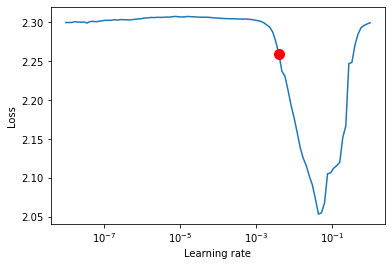

In [12]:
# logger = TensorBoardLogger(save_dir='logs/find_lr')
# trainer = pl.Trainer(gpus=1, max_epochs=50, logger=logger, early_stop_callback=early_stop_cb)

lr_finder = trainer.lr_find(model, dataset)

fig = lr_finder.plot(suggest=True)
fig.show()

In [13]:
# trainer

# > <pytorch_lightning.trainer.trainer.Trainer at 0x1b886c29d90>

In [14]:
# lr_finder = trainer.tuner.lr_find(model, dataset)

# > AttributeError: 'Trainer' object has no attribute 'tuner'

In [15]:
model.lr = lr_finder.suggestion()
model.lr

0.003981071705534969

In [16]:
trainer.fit(model, dataset)

D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


1

In [17]:
trainer.test(model, ckpt_path='best', verbose=True, datamodule=dataset)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8886, device='cuda:0'),
 'test_loss': tensor(0.4643, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 0.8886345624923706, 'test_loss': 0.46427470445632935}]